## MLE Take Home Assignment

This assignment will contains a total of 5 questions that generally guide you through a sample project involving a Machine Learning Engineer (MLE)

The entire assignment should takes around 60 minutes

### Spark Setup and IO

We are using Apache Spark as the main cluster engine, and pySpark as the python interface.<br>
If you do not have a spark cluster, you can set up a local spark following the [link](https://medium.com/codex/setup-a-spark-cluster-step-by-step-in-10-minutes-922c06f8e2b1).

#### Task 1
Initiate your spark session and read the given parquet file at "take_home_task_1.parquet"<br>
Print the schema and show top 5 rows of the data

In [1]:
### Your Code here
import findspark
findspark.init()

import pyspark
from pyspark.sql.functions import col,udf,asc,desc,when
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

df = spark.sql('''select 'pyspark is ready' AS message''')
df.show()

+----------------+
|         message|
+----------------+
|pyspark is ready|
+----------------+



In [2]:
#input the data into here

inputDF = spark.read.parquet("take_home_task1.snappy.parquet")
inputDF.show()

#Print Schema of the parquet file
inputDF.printSchema()

#Print top 5 row of the data
inputDF.show(5)

+---------+------------------+-----------------+
|msisdn_no|data_byte_usge_qty|durn_scds_usge_tm|
+---------+------------------+-----------------+
|   887166|             77512|           470.00|
|   831758|             45032|           370.00|
|   745388|              9588|            40.00|
|   809293|            266276|           180.00|
|   976517|             40867|           260.00|
|   589953|                52|           180.00|
|   371432|           2168740|         10680.00|
|   797848|            509033|           450.00|
|   301803|             28914|           200.00|
|   877443|             34603|          1130.00|
+---------+------------------+-----------------+

root
 |-- msisdn_no: long (nullable = true)
 |-- data_byte_usge_qty: long (nullable = true)
 |-- durn_scds_usge_tm: decimal(19,2) (nullable = true)

+---------+------------------+-----------------+
|msisdn_no|data_byte_usge_qty|durn_scds_usge_tm|
+---------+------------------+-----------------+
|   887166|      

### Task 2 Feature Engineering

data_byte_usge_qty is total usage quanty in kilobytes (kB) <br>
durn_scds_usge_tm is total usage time in seconds <br><br>

Now create 2 new columns:<br>
1. **avg_usge** : Average quanty per second 
2. **category** :Category of user following the below logic 
    - A if greater than 1 mb/s
    - B if in between 1 mb/s to 1 kb/s
    - C if less than 1 kb/s
    
Use an user defined function (UDF) to create the category column<br>
Show top 5 rows of resultant table <br><br>
Also show group by category count

In [3]:
### Your Code here
avg_usgeDF = inputDF.withColumn("avg_usge",col("data_byte_usge_qty")/col("durn_scds_usge_tm"))
avg_usgeDF.show()

#Create udf function to categories the 
def match_category(usage):
    if usage > 1000:
        return "A"
    elif usage < 1000 and usage > 1:
        return "B"
    else:
        return "C"

category_func = udf(match_category)
finalDF = avg_usgeDF.withColumn("category",category_func(avg_usgeDF['avg_usge']))

finalDF.show(5)

#Count the number of category and show in ascending order
category_counter=finalDF.groupBy("category").count()
category_counter.orderBy("category").show(truncate=False)

+---------+------------------+-----------------+--------------------+
|msisdn_no|data_byte_usge_qty|durn_scds_usge_tm|            avg_usge|
+---------+------------------+-----------------+--------------------+
|   887166|             77512|           470.00|164.9191489361702128|
|   831758|             45032|           370.00|121.7081081081081081|
|   745388|              9588|            40.00|239.7000000000000000|
|   809293|            266276|           180.00|1479.311111111111...|
|   976517|             40867|           260.00|157.1807692307692308|
|   589953|                52|           180.00|  0.2888888888888889|
|   371432|           2168740|         10680.00|203.0655430711610487|
|   797848|            509033|           450.00|1131.184444444444...|
|   301803|             28914|           200.00|144.5700000000000000|
|   877443|             34603|          1130.00| 30.6221238938053097|
+---------+------------------+-----------------+--------------------+

+---------+--------

### Task 3a Alternative Way
Use WHEN clause for re-create the cateogry column, name it **category_alt**<br>
show top 5 rows of resultant table

In [4]:
### Your Code here
# from pyspark.sql.functions import when

alte_finalDF = finalDF.withColumn("category_alt",when(finalDF.avg_usge > 1000, "A").when(finalDF.avg_usge > 1, "B").otherwise("C"))
alte_finalDF.select("msisdn_no","data_byte_usge_qty","durn_scds_usge_tm","avg_usge","category_alt").show(5)

#df.select(df.columns[:3]).show(3)

#Count the number of category and show in ascending order
alte_category_counter=alte_finalDF.groupBy("category_alt").count()
alte_category_counter.orderBy("category_alt").show(truncate=False)

+---------+------------------+-----------------+--------------------+------------+
|msisdn_no|data_byte_usge_qty|durn_scds_usge_tm|            avg_usge|category_alt|
+---------+------------------+-----------------+--------------------+------------+
|   887166|             77512|           470.00|164.9191489361702128|           B|
|   831758|             45032|           370.00|121.7081081081081081|           B|
|   745388|              9588|            40.00|239.7000000000000000|           B|
|   809293|            266276|           180.00|1479.311111111111...|           A|
|   976517|             40867|           260.00|157.1807692307692308|           B|
+---------+------------------+-----------------+--------------------+------------+
only showing top 5 rows

+------------+-----+
|category_alt|count|
+------------+-----+
|A           |2    |
|B           |7    |
|C           |1    |
+------------+-----+



### Task 3b Explain in a few words which method is perferred and why.

// Your answer here

I would use the WHEN clause method in Task 3a.

The reason for this is because it is a Spark SQL build-in functions and these build-in functions provides optimisation when running it. Plus, it is convenient and easy to use. 

User Defined Function (UDF) can get the job done too, however, PySpark cannot apply optimisation to it and it will cause the lost optimisation on Dataframe/Dataset done by Pyspark. Hence why using PySpark build-in functions should be consider first before using UDF.

### Task 4 Job Triggering

1. Compile task 1-3 into a single .py file with the output of showing first 5 rows of the final table to STDOUT
2. Create a MakeFile with a single recipe to run the python file
3. Trigger your job here in the notebook and show the output. You should use the subprocess module

In [5]:
### Your Code here
import subprocess

# cmd="make -f the_recipe.mak"

trigger_process = subprocess.run(["python", "take_home.py"], capture_output=True, text=True)
print(trigger_process.stdout)

/opt/anaconda3/bin/python3 take_home.py
+---------+------------------+-----------------+--------------------+--------+
|msisdn_no|data_byte_usge_qty|durn_scds_usge_tm|            avg_usge|category|
+---------+------------------+-----------------+--------------------+--------+
|   887166|             77512|           470.00|164.9191489361702128|       B|
|   831758|             45032|           370.00|121.7081081081081081|       B|
|   745388|              9588|            40.00|239.7000000000000000|       B|
|   809293|            266276|           180.00|1479.311111111111...|       A|
|   976517|             40867|           260.00|157.1807692307692308|       B|
|   589953|                52|           180.00|  0.2888888888888889|       C|
|   371432|           2168740|         10680.00|203.0655430711610487|       B|
|   797848|            509033|           450.00|1131.184444444444...|       A|
|   301803|             28914|           200.00|144.5700000000000000|       B|
|   877443| 

NOTE: I apologise for this but i could not run my MakeFile in jupyter notebook. However, i managed to run it over on Windows command prompt. Here is the screenshot of the result. Furthermore, i have attached the Makefile in the GitHub and this is the command i ran "make -f the_recipe.mak"

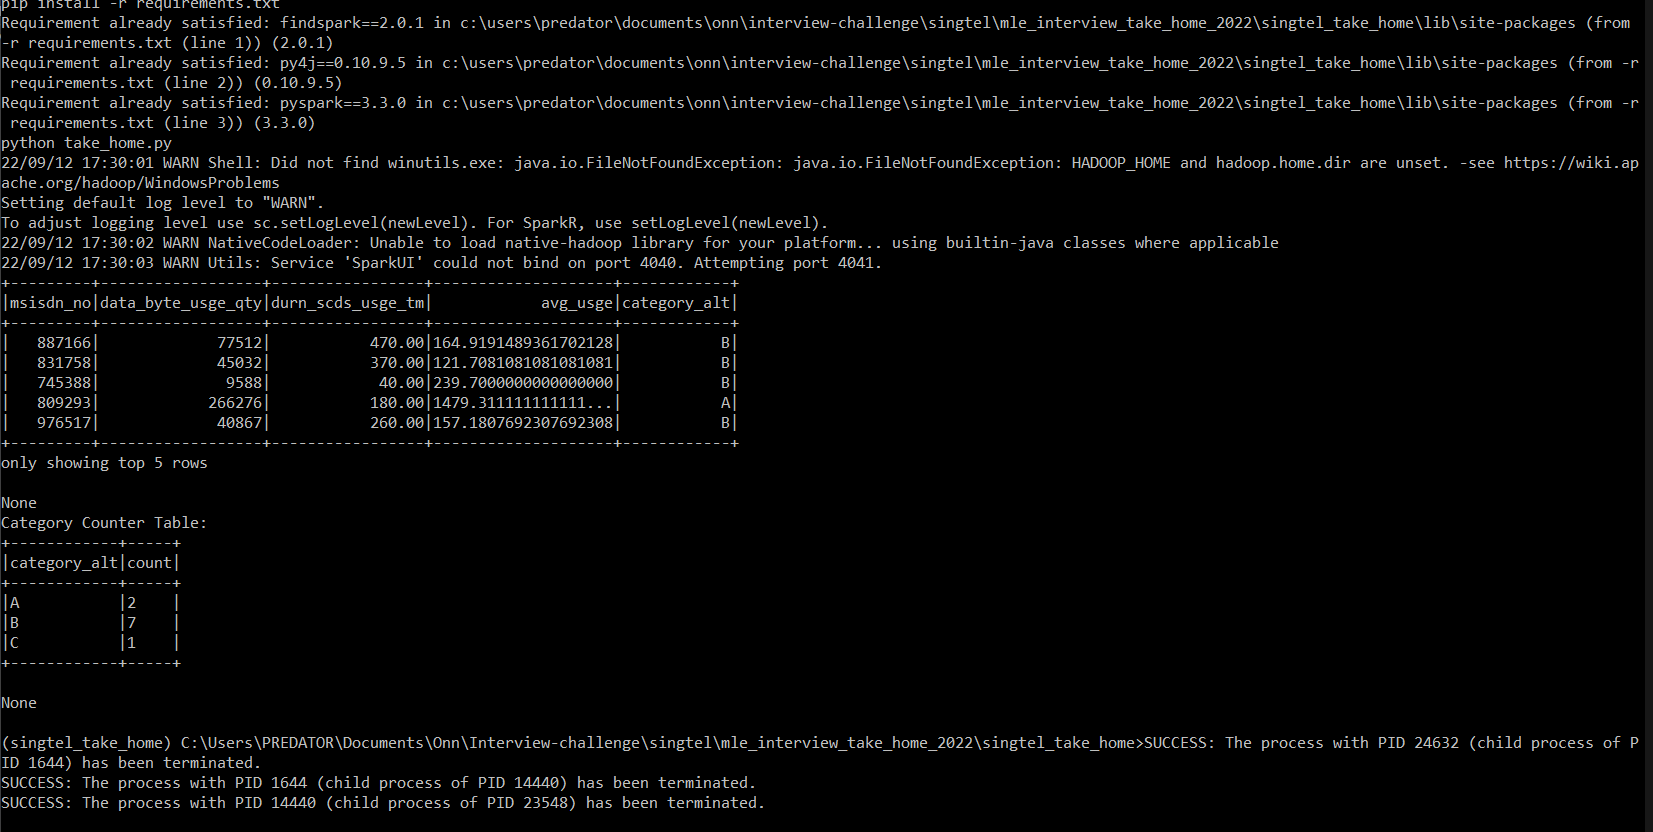


### Task 5 Git and submission 

We use git extentively for version control

To submit your assignment,
1. Create a repo that you wish to share with us, ideally empty
2. Create a branch called singtel_mle_take_home
3. Add, Commit and push this notebook and your .py file to the branch
4. Submit to us a pull request